In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data loading

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/周一周四代码表格/olist_orders_dataset.csv')
review_data = pd.read_excel('/content/drive/MyDrive/周一周四代码表格/olist_order_reviews_dataset_English.xlsx')
data = data.dropna()

## Data preprocessing

#### Change time format

In [ ]:
for col in ['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date']:
    if data[col].dtype == 'object':
        data[col] = pd.to_datetime(data[col])

<ipython-input-167-a4bc35ccc065>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = pd.to_datetime(data[col])


#### Remove outliers

In [ ]:
data = data[data['order_approved_at']>data['order_purchase_timestamp']]
data = data[data['order_estimated_delivery_date']>data['order_delivered_carrier_date']]
data = data[data['order_delivered_customer_date']>data['order_delivered_carrier_date']]

#### Create a time period column

In [ ]:
# 订单确认时间
data['approved_time'] = data['order_approved_at']-data['order_purchase_timestamp']
# 预计运输时间
data['pre_time'] = data['order_estimated_delivery_date']-data['order_delivered_carrier_date']
# 实际运输时间
data['actual_time'] = data['order_delivered_customer_date']-data['order_delivered_carrier_date']
# 实际运输时间
data['delay_time'] = data['actual_time']-data['pre_time']

In [ ]:
data[['approved_time','pre_time','actual_time']].describe()

,approved_time,pre_time,actual_time
count,94723,94723,94723
mean,0 days 10:22:58.133885117,20 days 14:59:37.681323438,9 days 08:11:06.380034416
std,0 days 20:27:20.902906434,8 days 14:11:04.649793222,8 days 14:53:20.801821307
min,0 days 00:05:19,0 days 00:12:44,0 days 00:00:01
25%,0 days 00:13:06,14 days 23:27:13,4 days 02:34:02.500000
50%,0 days 00:20:59,20 days 07:09:00,7 days 02:37:54
75%,0 days 14:51:05.500000,25 days 15:56:49.500000,12 days 01:13:23
max,30 days 21:26:37,192 days 10:25:00,205 days 04:35:00


In [ ]:
#订单延迟程度
data['delay_rate'] = (data['actual_time']-data['pre_time'])/data['pre_time']

#### Remove exception delay_rate

In [ ]:
def remove_outliers_iqr(data):
  q1 = np.percentile(data,25)
  q3 = np.percentile(data,75)
  iqr = q3-q1

  lower_bound = q1 - 1.5*iqr
  upper_bound = q3 + 1.5*iqr

  # return data[(data>lower_bound) & (data<upper_bound)]
  return lower_bound,upper_bound

In [ ]:
data = data[(data['delay_rate']>remove_outliers_iqr(data['delay_rate'])[0]) & (data['delay_rate']<remove_outliers_iqr(data['delay_rate'])[1])]

In [ ]:
merge_df = pd.merge(data,review_data,on='order_id')

In [ ]:
merge_df['delay_time_num'] = pd.to_numeric(merge_df['delay_time'])

In [ ]:
scaler = StandardScaler()
merge_df[['delay_rate_scaler','review_score_scaler','delay_time_num_scaler']] = pd.DataFrame(scaler.fit_transform(merge_df[['delay_rate','review_score','delay_time_num']]))

In [ ]:
merge_df['order_purchase_timestamp_year_month'] = merge_df['order_purchase_timestamp'].dt.strftime('%Y-%m')

In [ ]:
merge_df[['delay_rate_scaler','review_score_scaler','delay_time_num_scaler']]

,delay_rate_scaler,review_score_scaler,delay_time_num_scaler
0,0.318350,-0.239372,0.761009
1,1.339364,-0.239372,0.994233
2,-0.179372,0.621261,-0.588739
3,0.146504,0.621261,-0.020851
4,-0.945653,0.621261,0.477335
...,...,...,...
89067,-0.631837,0.621261,-0.361144
89068,2.442573,-0.239372,1.538819
89069,1.860169,0.621261,0.971723
89070,0.051465,-1.960638,-0.957972


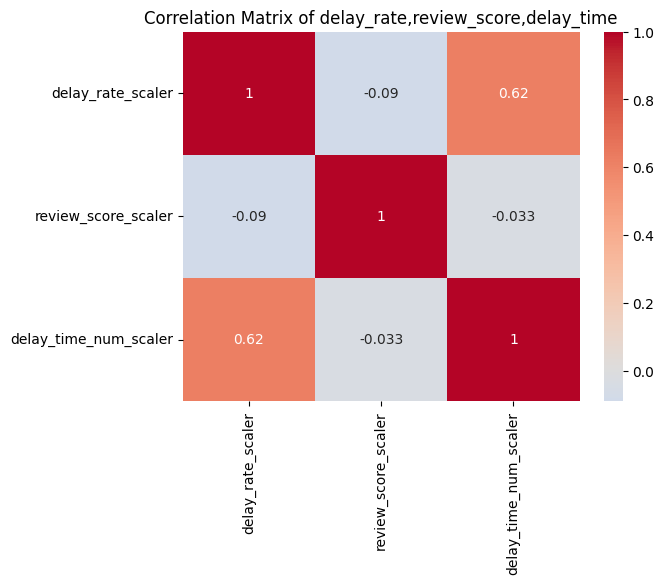

In [ ]:
corr_matrix = merge_df[['delay_rate_scaler','review_score_scaler','delay_time_num_scaler']].corr()

sns.heatmap(corr_matrix,annot=True,cmap='coolwarm',center = 0)

plt.title('Correlation Matrix of delay_rate,review_score,delay_time')
plt.show()